In [2]:
!date

Wed May 27 18:54:24 UTC 2020


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
!pip install anndata

     |████████████████████████████████| 122kB 8.0MB/s 


In [5]:
!pip install scanpy

     |████████████████████████████████| 7.2MB 6.2MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 


###**Import Packages** 

In [0]:
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
import scipy.sparse

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import (KNeighborsClassifier,NeighborhoodComponentsAnalysis)
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline
sc.set_figure_params(dpi=125)

import seaborn as sns
sns.set(style="whitegrid")

##**Analysis of Cell Atlas**
### From merged starvation and stimulation data


Read in original, experimental data

In [9]:
#Starvation data
path = './drive/My Drive/Colab Notebooks/data/starvation'
bus_fs = anndata.read(path+"/bus_fs_combo_filtered_leiden.h5ad")
cellRanger_fs = anndata.read(path+"/clytia_fed_starved_JAG_20190424.h5ad")

print(bus_fs)
print(cellRanger_fs)

#Stimulation data
path = './drive/My Drive/Colab Notebooks/data/stimulation'
bus_stim = anndata.read(path+"/jelly4stim_bus_combo_noZero_filtered_leiden.h5ad")
print(bus_stim)

AnnData object with n_obs × n_vars = 13673 × 8696
    obs: 'batch', 'n_counts', 'n_countslog', 'louvain', 'leiden', 'orgID', 'fed', 'starved', 'fed_neighbor_score'
    var: 'n_counts'
    uns: 'fed_neighbor_score_colors', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
AnnData object with n_obs × n_vars = 13673 × 2657
    obs: 'n_counts', 'n_countslog', 'louvain', 'orgID', 'fed', 'starved', 'fed_ord', 'starved_ord', 'new_fed', 'fed_neighbor_score'
    var: 'n_counts', 'n_cells'
    uns: 'fed_ord_colors', 'louvain', 'louvain_colors', 'louvain_sizes', 'neighbors', 'new_fed_colors', 'orgID_colors', 'paga', 'pca', 'rank_genes_groups', 'starved_ord_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
AnnData object with n_obs × n_vars = 19054 × 10260
    obs: 'batch', 'n_counts', 'n_countslog', 'leiden', 'condition', 'orgID

Read in merged data

In [8]:
path = './drive/My Drive/Colab Notebooks/data/merged'

#scVI annotations of cells, with latent dimensions and onyl including highly variable genes
adata = anndata.read(path+"/scVI_latent30_combo.h5ad")
print(adata)

#scVI annotations of cells, including all nonzero genes
combo = anndata.read(path + "/bus_stim_fs_latent30_combo.h5ad")
print(combo)

AnnData object with n_obs × n_vars = 32727 × 2873
    obs: 'leiden_scVI', 'cell_origin', 'Z_0', 'Z_1', 'Z_2', 'Z_3', 'Z_4', 'Z_5', 'Z_6', 'Z_7', 'Z_8', 'Z_9', 'Z_10', 'Z_11', 'Z_12', 'Z_13', 'Z_14', 'Z_15', 'Z_16', 'Z_17', 'Z_18', 'Z_19', 'Z_20', 'Z_21', 'Z_22', 'Z_23', 'Z_24', 'Z_25', 'Z_26', 'Z_27', 'Z_28', 'Z_29'
    uns: 'leiden', 'leiden_scVI_colors', 'neighbors'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'distances', 'connectivities'
AnnData object with n_obs × n_vars = 32727 × 46716
    obs: 'batch', 'leiden_scVI', 'cell_origin'
    obsm: 'X_scVI', 'X_umap'


**Labeling and analysis of condition distribution within merged data**

In [0]:
#Map cellRanger clusters to Kallisto bus data
bus_fs.obs['louvain_cellRanger'] = cellRanger_fs.obs['louvain']

In [13]:
#Set 'condition' observatin as 'fed' or 'starved' for ease of visualization
conds = []
for i in bus_fs.obs['fed']:
    if i == True:
        conds += ['fed']
    else:
        conds += ['starved']
bus_fs.obs['condition'] = pd.Categorical(conds)
bus_fs

AnnData object with n_obs × n_vars = 13673 × 8696
    obs: 'batch', 'n_counts', 'n_countslog', 'louvain', 'leiden', 'orgID', 'fed', 'starved', 'fed_neighbor_score', 'louvain_cellRanger', 'condition'
    var: 'n_counts'
    uns: 'fed_neighbor_score_colors', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [14]:
#Map conditions to cells in merged data
combo.obs['condition'] = list(bus_stim.obs['condition'])+list(bus_fs.obs['condition'])
combo

AnnData object with n_obs × n_vars = 32727 × 46716
    obs: 'batch', 'leiden_scVI', 'cell_origin', 'condition'
    obsm: 'X_scVI', 'X_umap'

In [0]:
#Make dataframe to store counts of each condition across cell map, per cluster
counts = pd.DataFrame(columns =['count','condition','cluster']) 
clusters = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24']

c = []
cond = []
clus = []

conds = ['SW','DI','KCl','fed','starved']
#Extract cells in each cluster
for cl in clusters:
    data = combo[combo.obs['leiden_scVI'].isin([cl])]
    
    #Count number of each experimental condition within cluster
    for cd in conds:
        c_data = data[data.obs['condition'].isin([cd])]
        
        c += [c_data.n_obs]
        cond += [cd]
        clus += [cl]
#print(len(c))
    
counts['count'] = c
counts['condition'] = cond
counts['cluster'] = clus

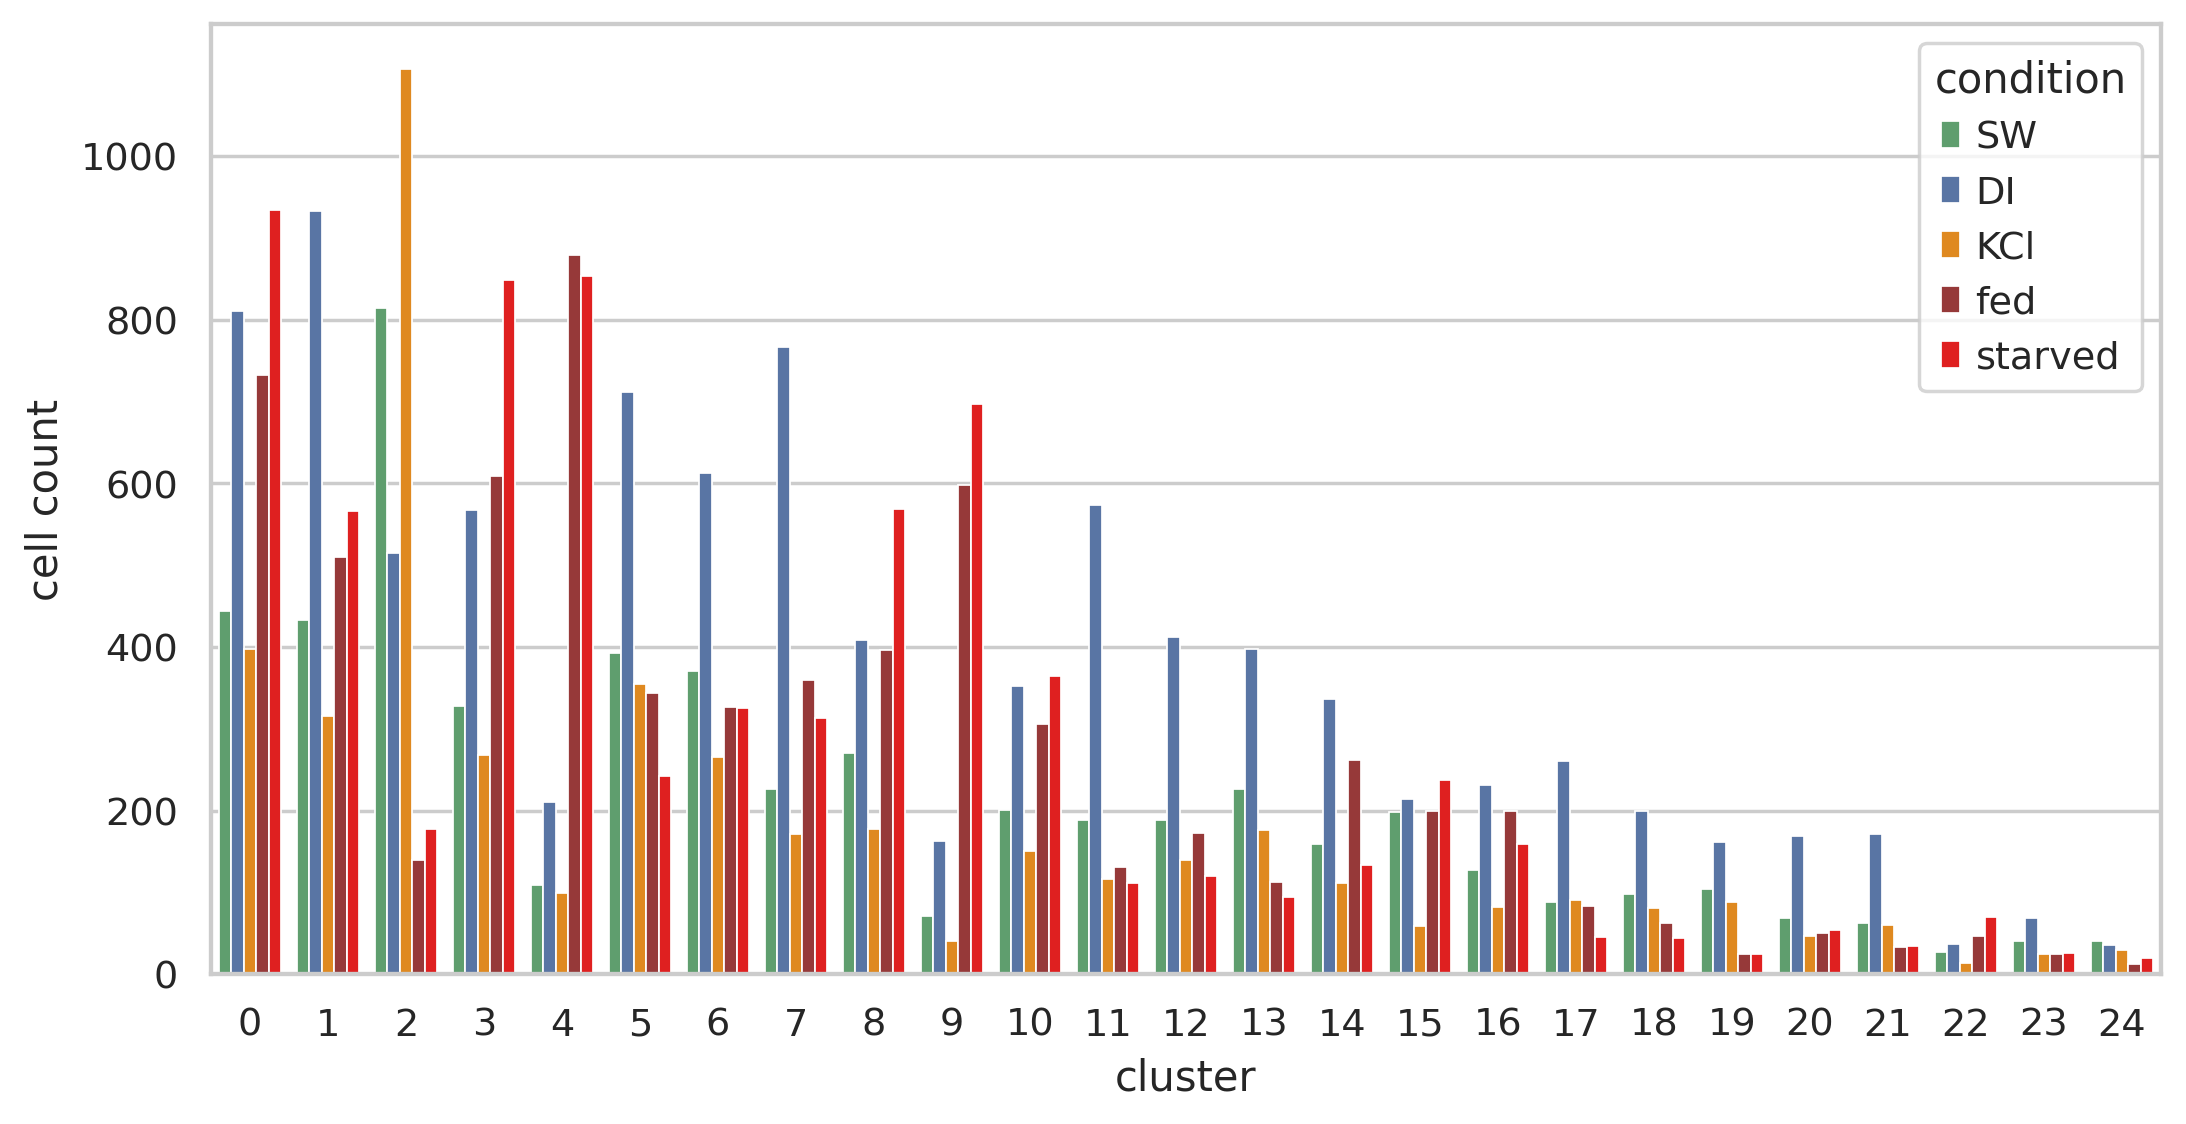

In [20]:
#Plot count distribution
counts['cluster'] = [int(i) for i in counts['cluster']] 
plt.figure(figsize=(10, 5))
ax = sns.barplot(x="cluster", y="count", hue="condition", data=counts,linewidth=0.5,palette=["g", "b","darkorange","brown","red"])
ax.set(ylabel='cell count')
plt.show()

**Marker gene analysis across clusters**

... storing 'condition' as categorical


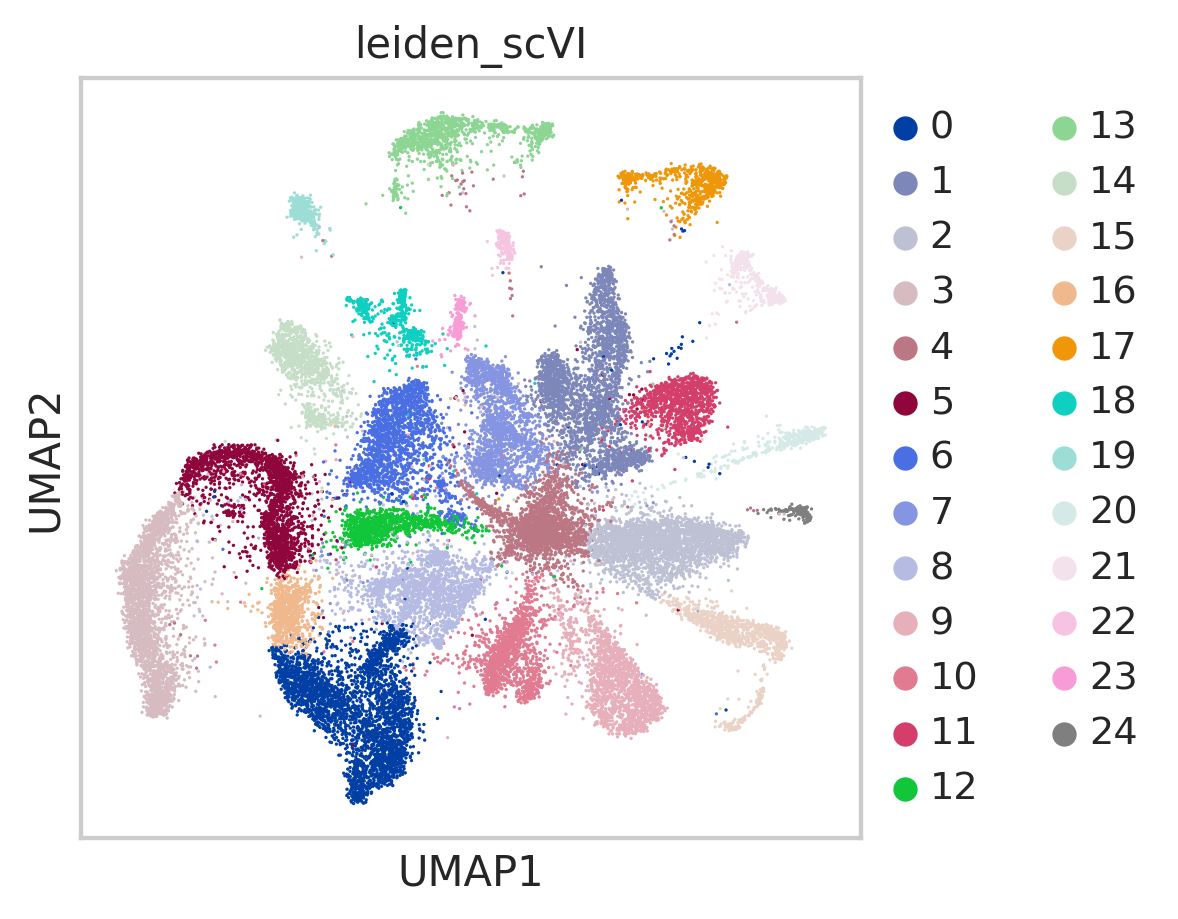

In [21]:
#Plot cell atlas
sc.pl.umap(combo,color='leiden_scVI')

In [0]:
#Normalize counts 
combo.raw = sc.pp.log1p(combo, copy=True)
sc.pp.normalize_per_cell(combo, counts_per_cell_after=1e4)

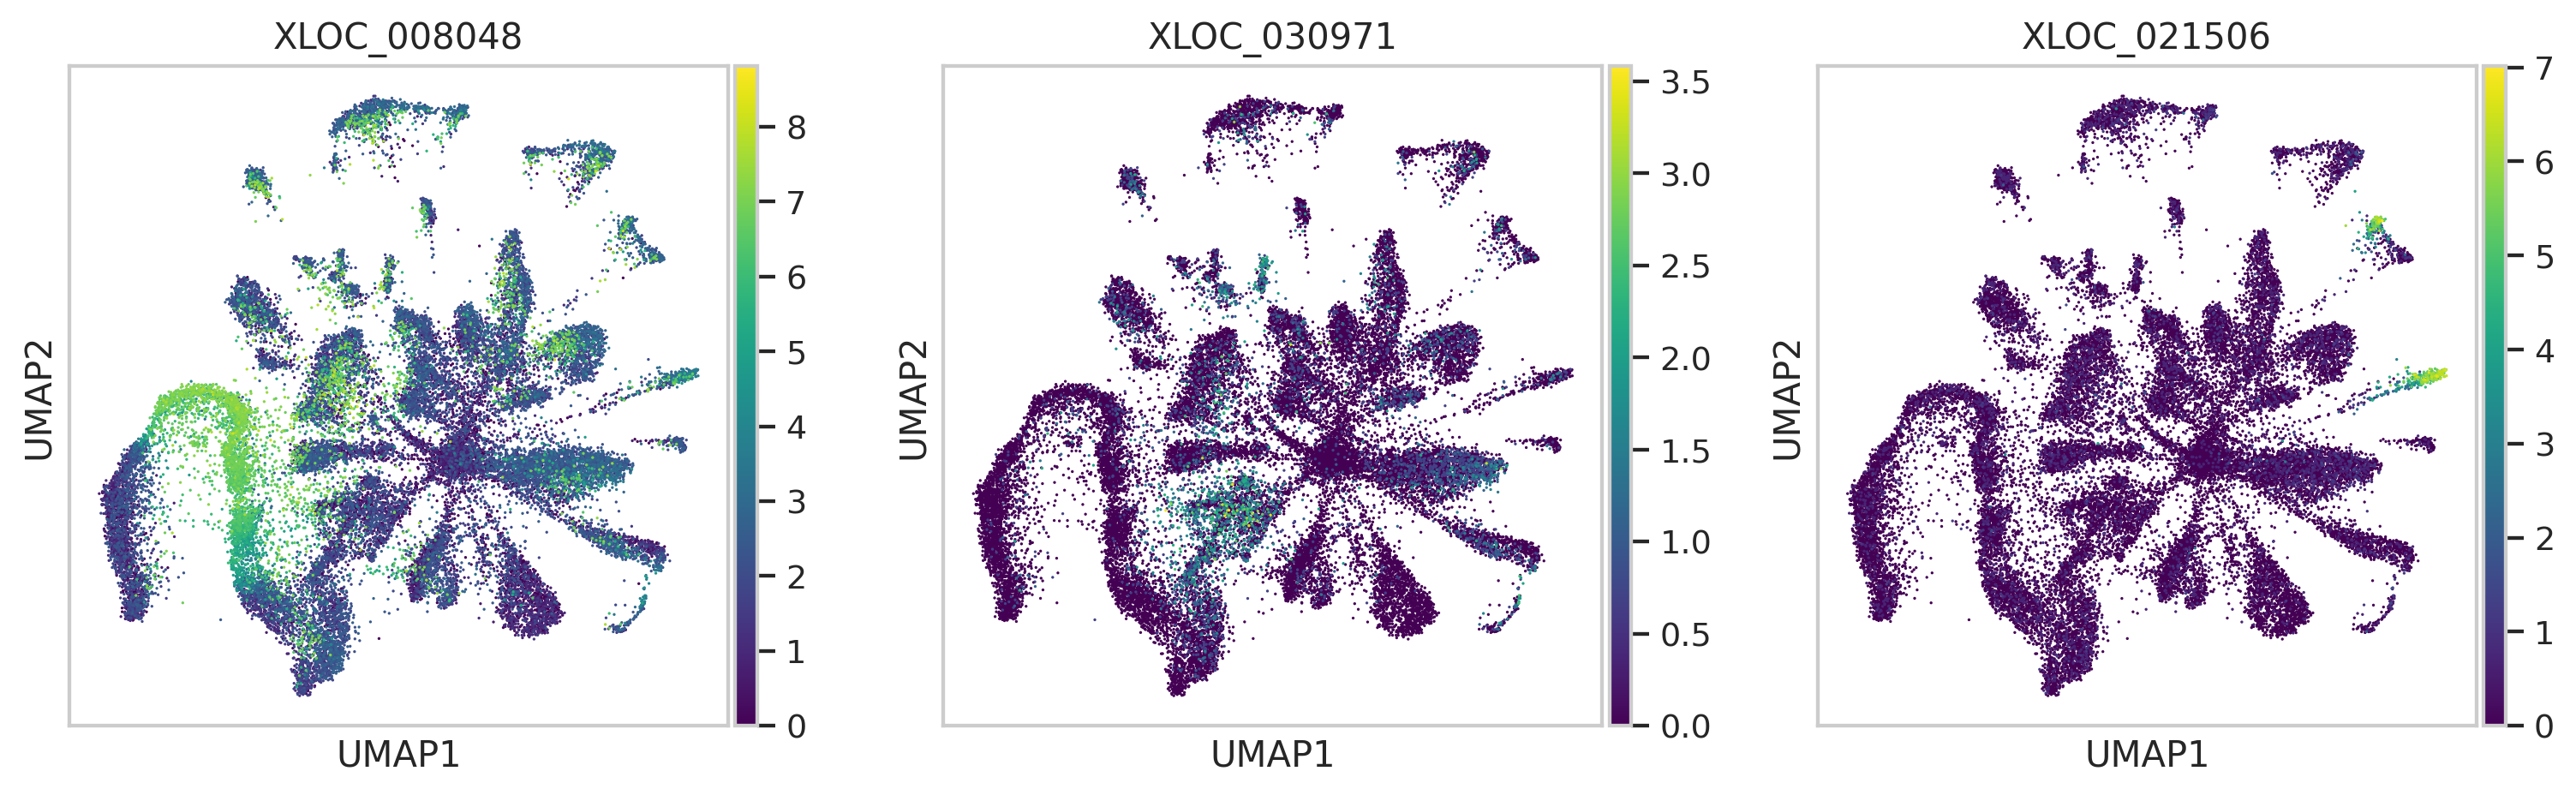

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

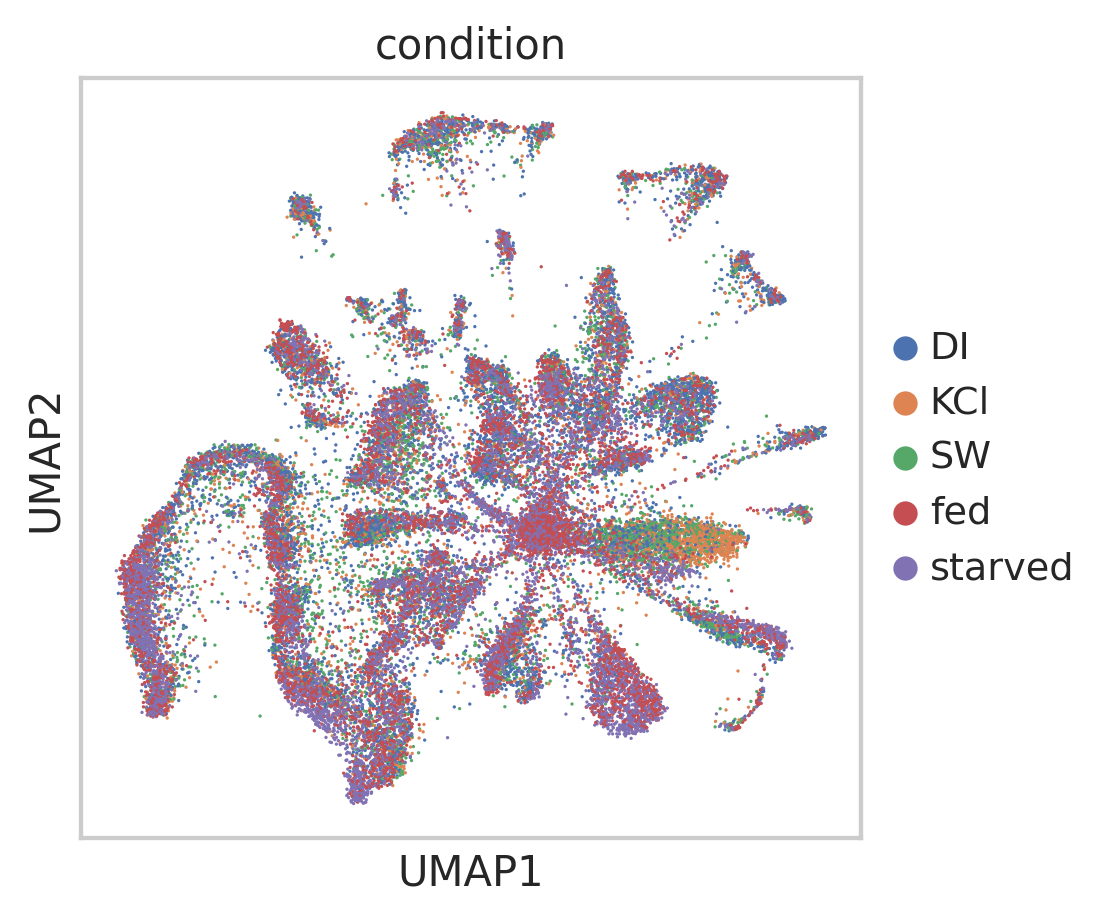

In [23]:
#Visualize specific genes on UMAP
sc.pl.umap(combo,color=['XLOC_008048','XLOC_030971','XLOC_021506'],color_map = 'viridis')
sc.pl.umap(combo,color=['condition'],color_map = 'viridis')

In [0]:
#Rank and extract marker genes for all clusters

#Keep top 15 genes
sc.tl.rank_genes_groups(combo, 'leiden_scVI', n_genes=15,method='t-test')

In [0]:
#Plot top marker gene for each cluster

markers = []
for i in np.unique(combo.obs['leiden_scVI']):
     markers += [combo.uns['rank_genes_groups']['names'][i][0]]

sc.pl.umap(combo,color=markers,color_map = 'viridis')

In [0]:
#Export top genes for each cluster
markerGenes = pd.DataFrame.from_records(combo.uns['rank_genes_groups']['names'])
#markerGenes.to_csv('./drive/My Drive/Colab Notebooks/markerGenes.csv')


In [0]:
#Export protein sequences for genes of interest

#Get protein sequences for Blasting

# !cd "drive/My Drive/Colab Notebooks/referenceData" && cut -c -11 full_rna_nr.fai > genes.txt
# known_genes = [line.rstrip('\n') for line in open('./drive/My Drive/Colab Notebooks/referenceData/genes.txt')]

# #Get marker genes for cluster
# genes = markerGene['4'].tolist()
# print(len(genes))
# #Filter genes for existing AA seqs
# genes = [x for x in genes if x in known_genes]
# print(len(genes))
# #Make fasta format
# genes = [">" + x for x in genes]
    
# with open('./drive/My Drive/Colab Notebooks/DE_genes.txt', 'w') as f:
#     for item in genes:
#         f.write("%s\n" % item)
            
# !cut -c 2- "DE_genes.txt" | xargs -n 1 samtools faidx full_rna_nr > .DE_genesAA.fa
# !rm DE_genes.txt

**Map experimental clusters to merged atlas**

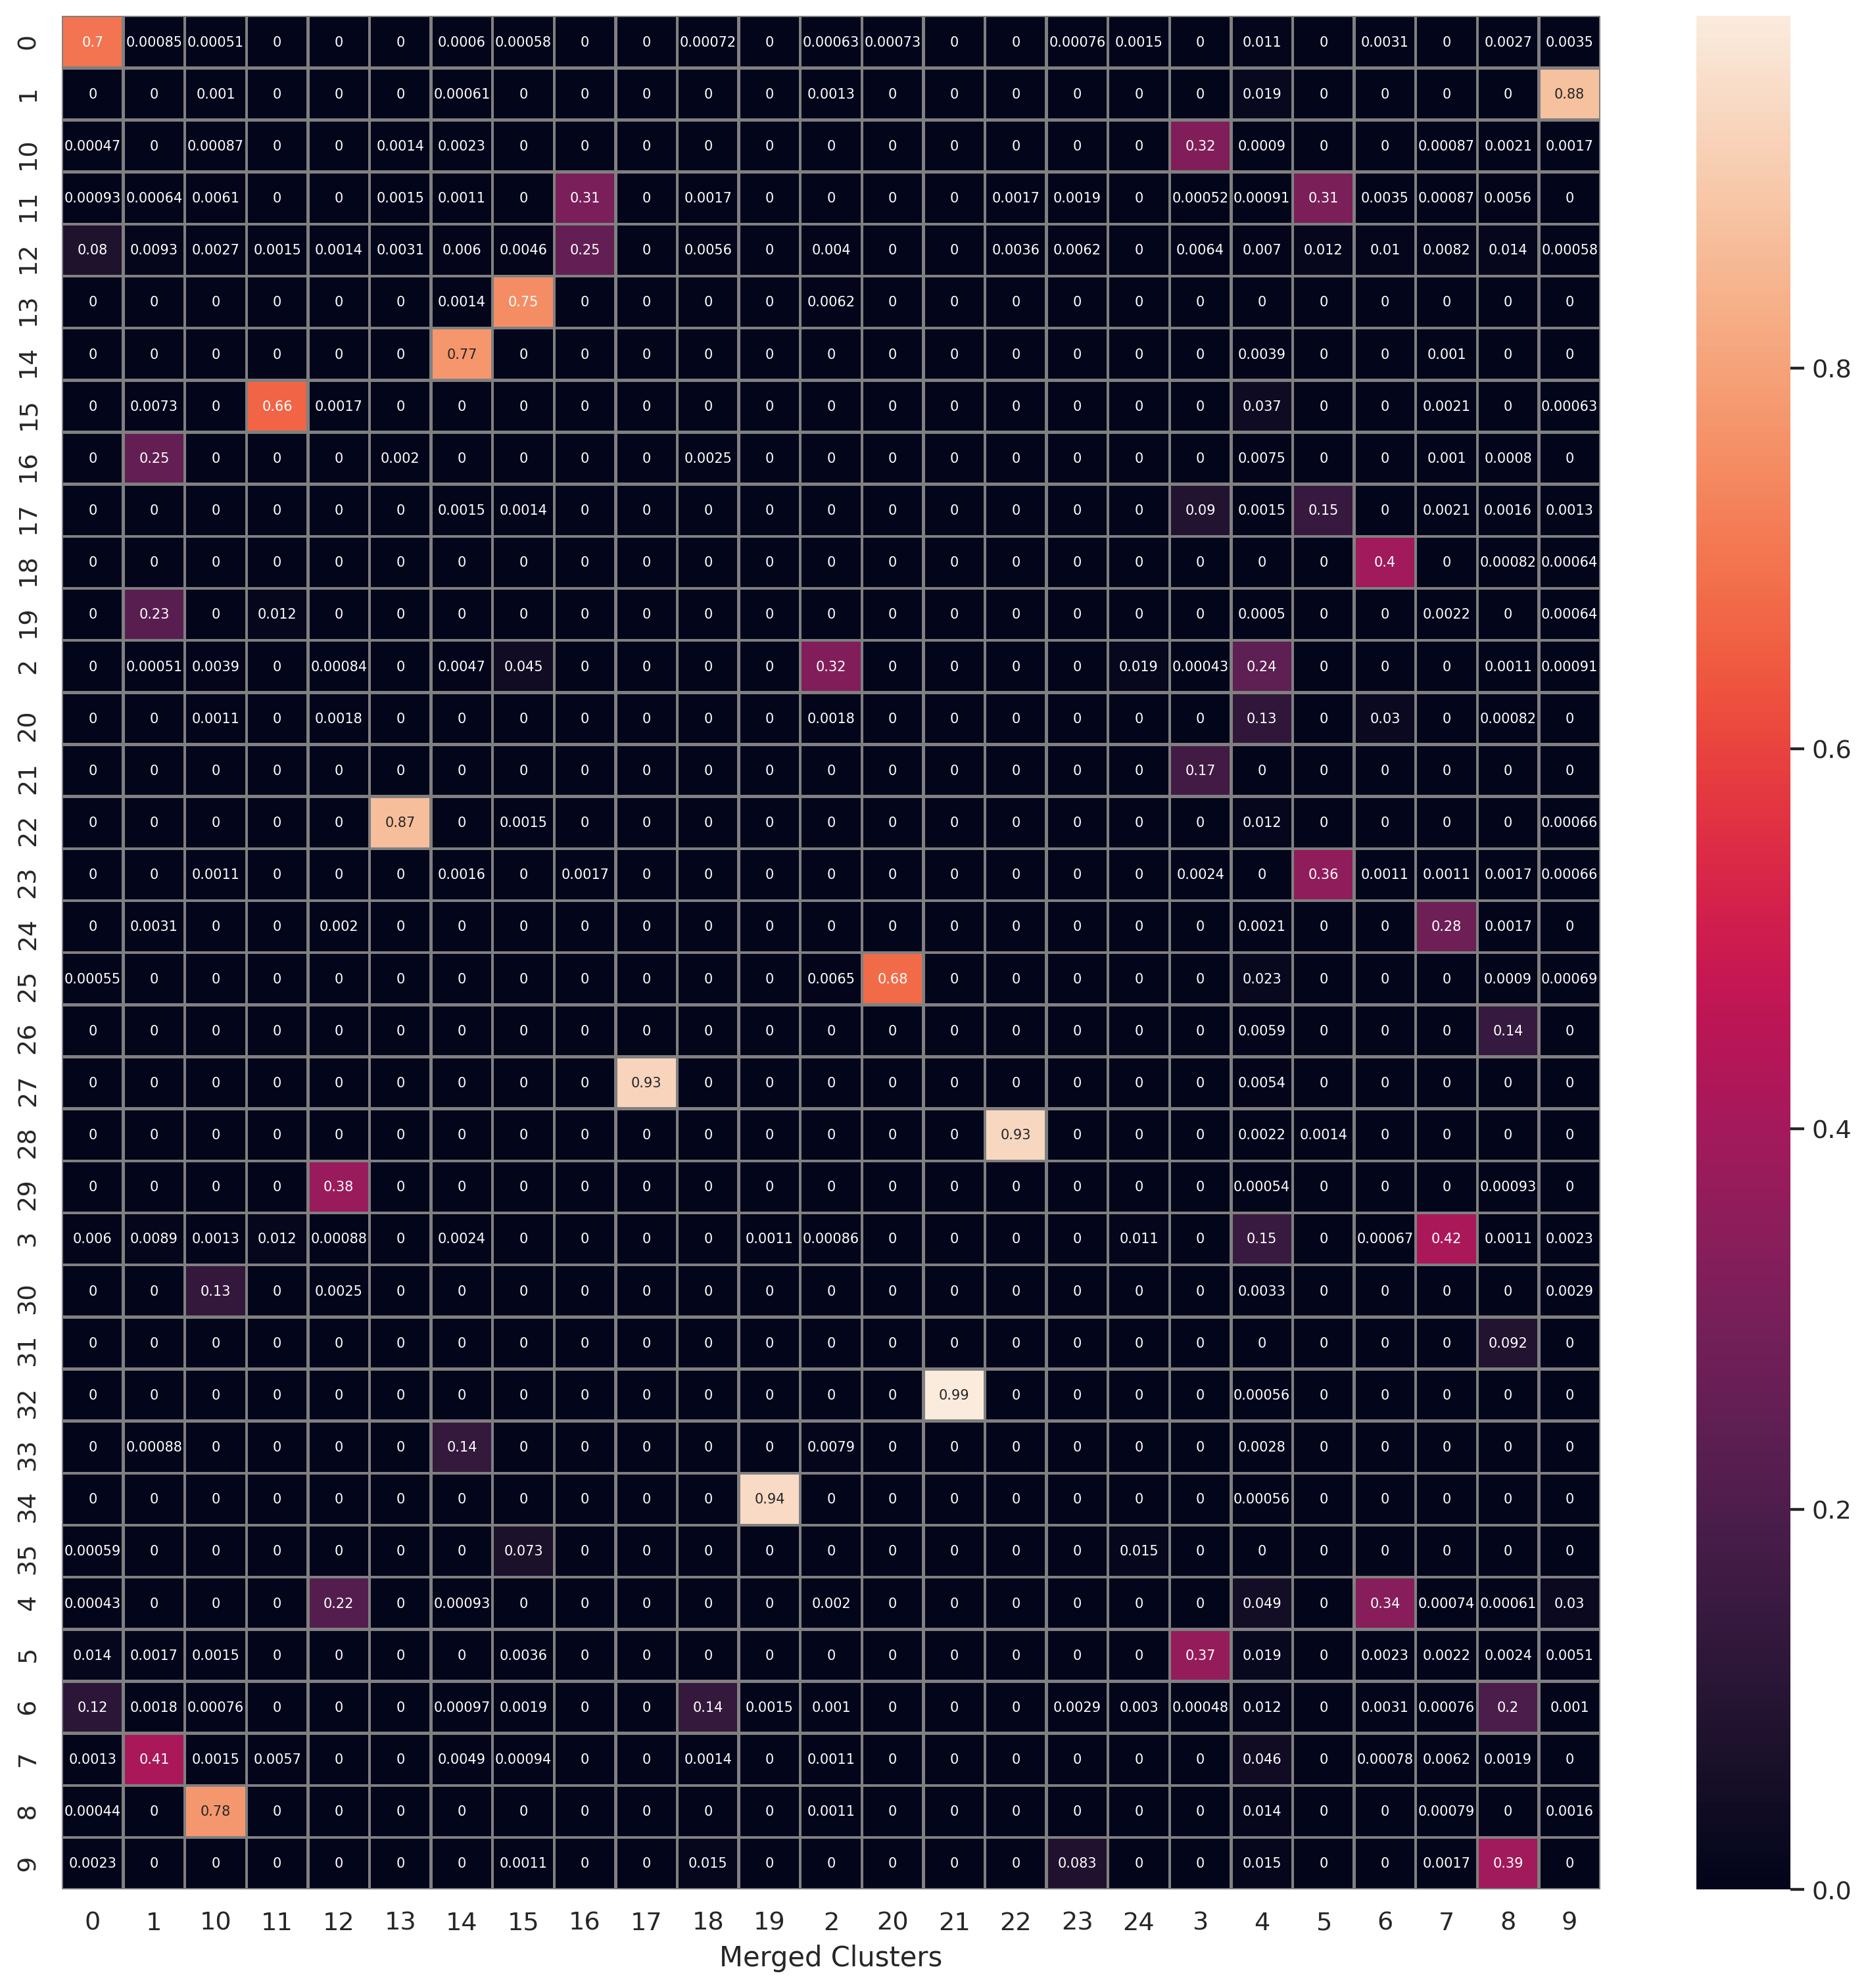

In [31]:
#Separate cells from each experiment
adata_fs = combo[combo.obs['cell_origin'].isin(['FS'])]
adata_fs

# Distribution of cellRanger clusters in leiden_scVI mapping (fed/starved)
fs_clusters = np.unique(adata_fs.obs['leiden_scVI'])
bus_fs_clusters = np.unique(bus_fs.obs['louvain_cellRanger']) #Or leiden

#Dataframe for overlap scores
clusterScores_bus = pd.DataFrame(index=bus_fs_clusters, columns=fs_clusters)

#Remove experimental identifier from cell barcodes
adata_fs.obs_names = [s.replace('_fs', '') for s in adata_fs.obs_names] 

for i in fs_clusters:
    #Get cell barcodes in each cluster
    sub =  adata_fs[adata_fs.obs['leiden_scVI'].isin([i])]
    sub_cells =  list(sub.obs_names)
    scores = []

    for j in bus_fs_clusters:
        #Get cell barcodes in each cluster
        bus_fs_sub =  bus_fs[bus_fs.obs['louvain_cellRanger'].isin([j])]
        bus_fs_sub_cells =  list(bus_fs_sub.obs_names)

        #Jaccard score calculation
        union = set(sub_cells).union(bus_fs_sub_cells)
        intersect = set(sub_cells).intersection(bus_fs_sub_cells)
        scores.append(len(intersect)/len(union))


    clusterScores_bus[i] = scores
    
plt.figure(figsize=(15,15))
ax = sns.heatmap(clusterScores_bus,annot=True, annot_kws={"size": 6},linewidths=1, linecolor='grey')
ax.set(xlabel='Merged Clusters')
plt.show()

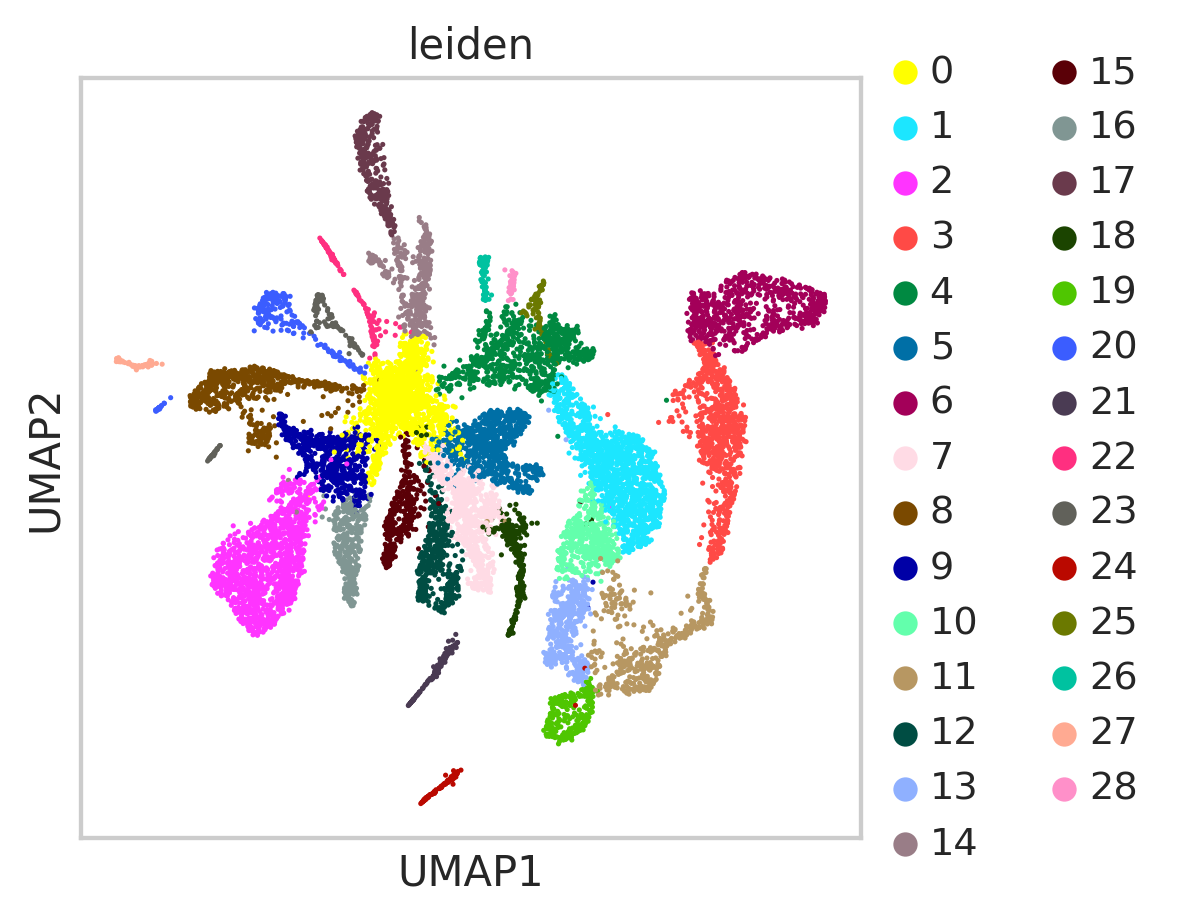

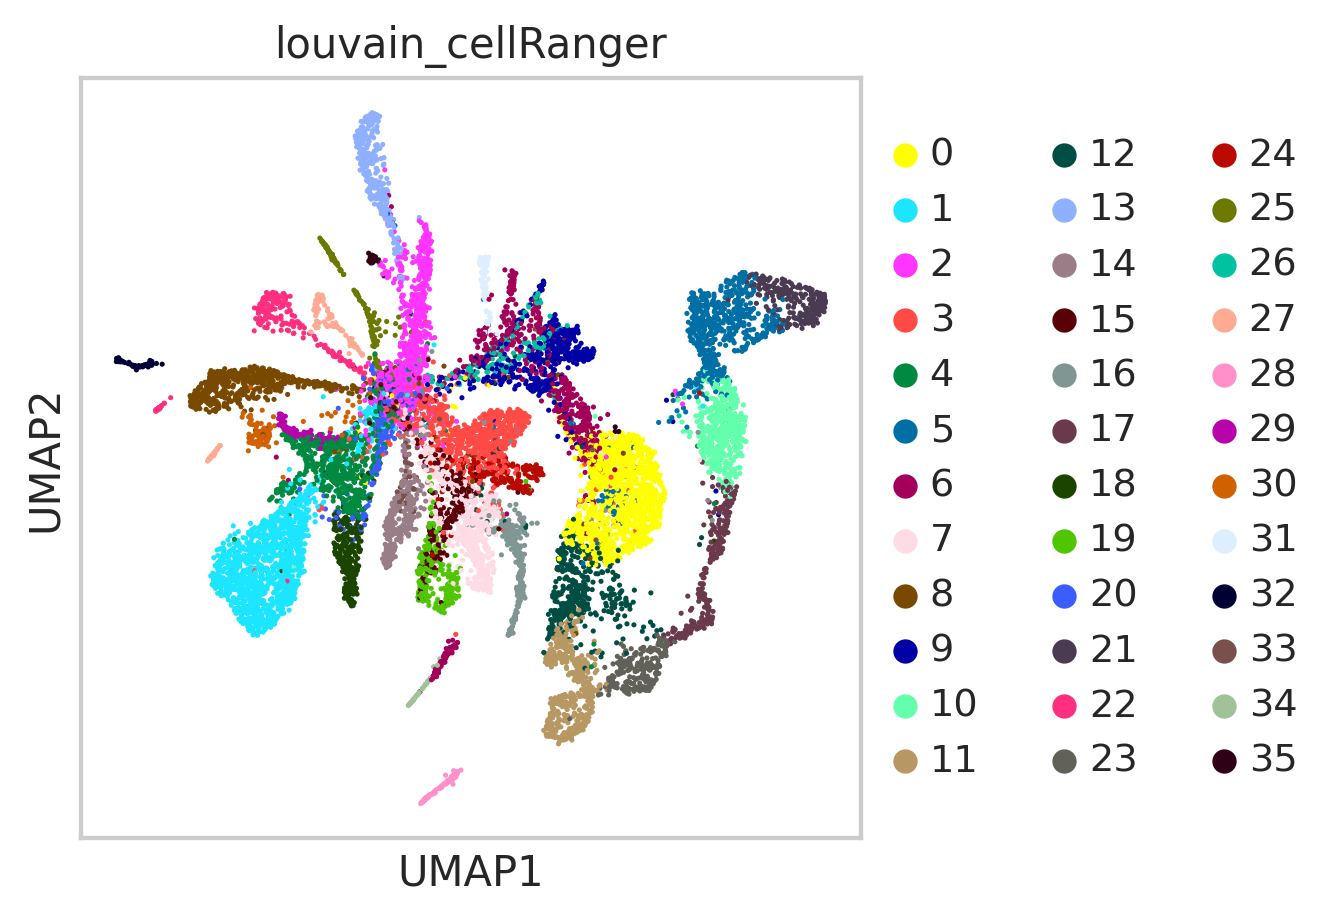

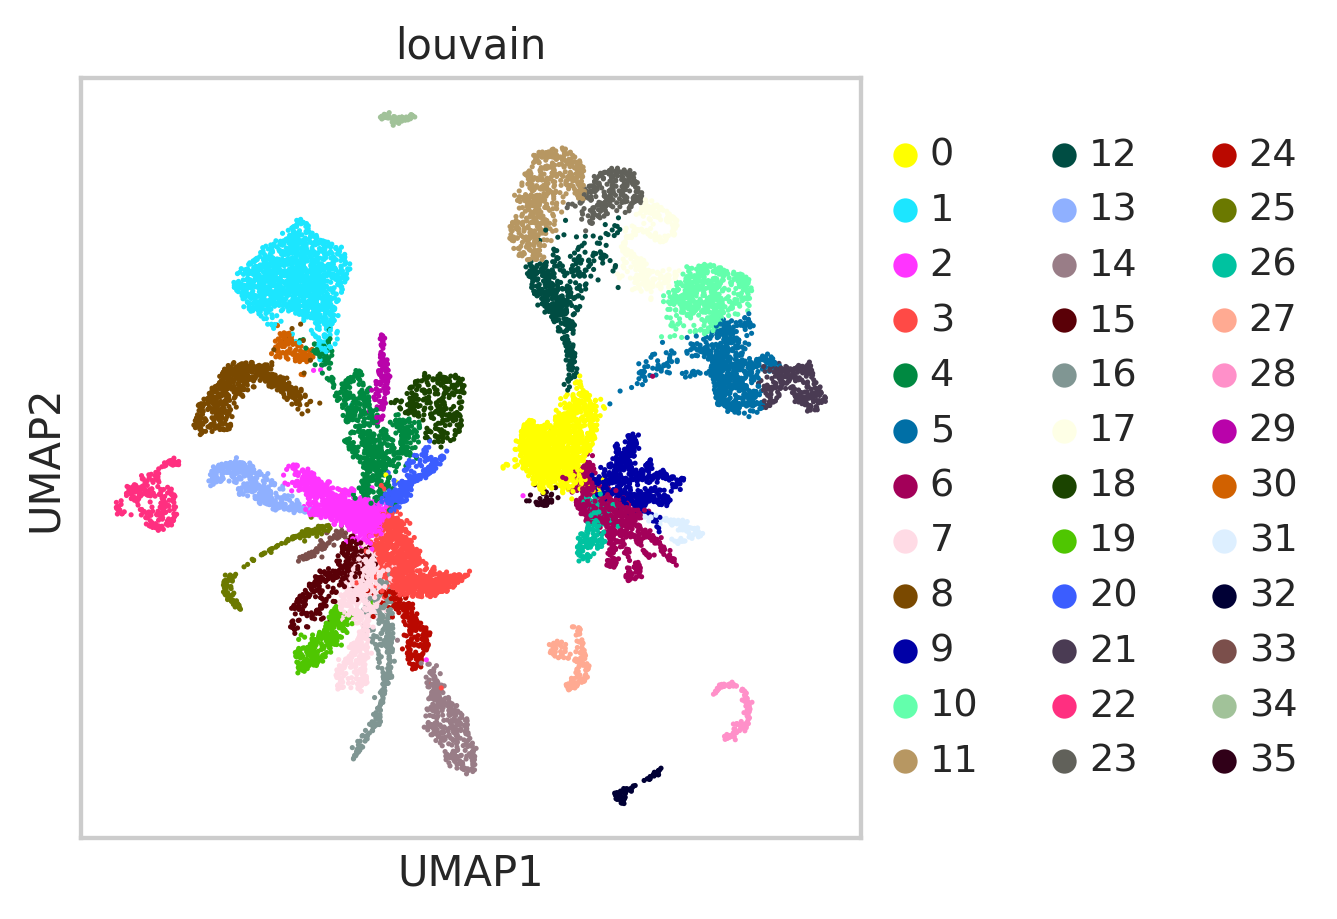

In [35]:
sc.pl.umap(bus_fs,color=['leiden'],color_map = 'viridis')
sc.pl.umap(bus_fs,color=['louvain_cellRanger'],color_map = 'viridis')
sc.pl.umap(cellRanger_fs,color=['louvain'],color_map = 'viridis')

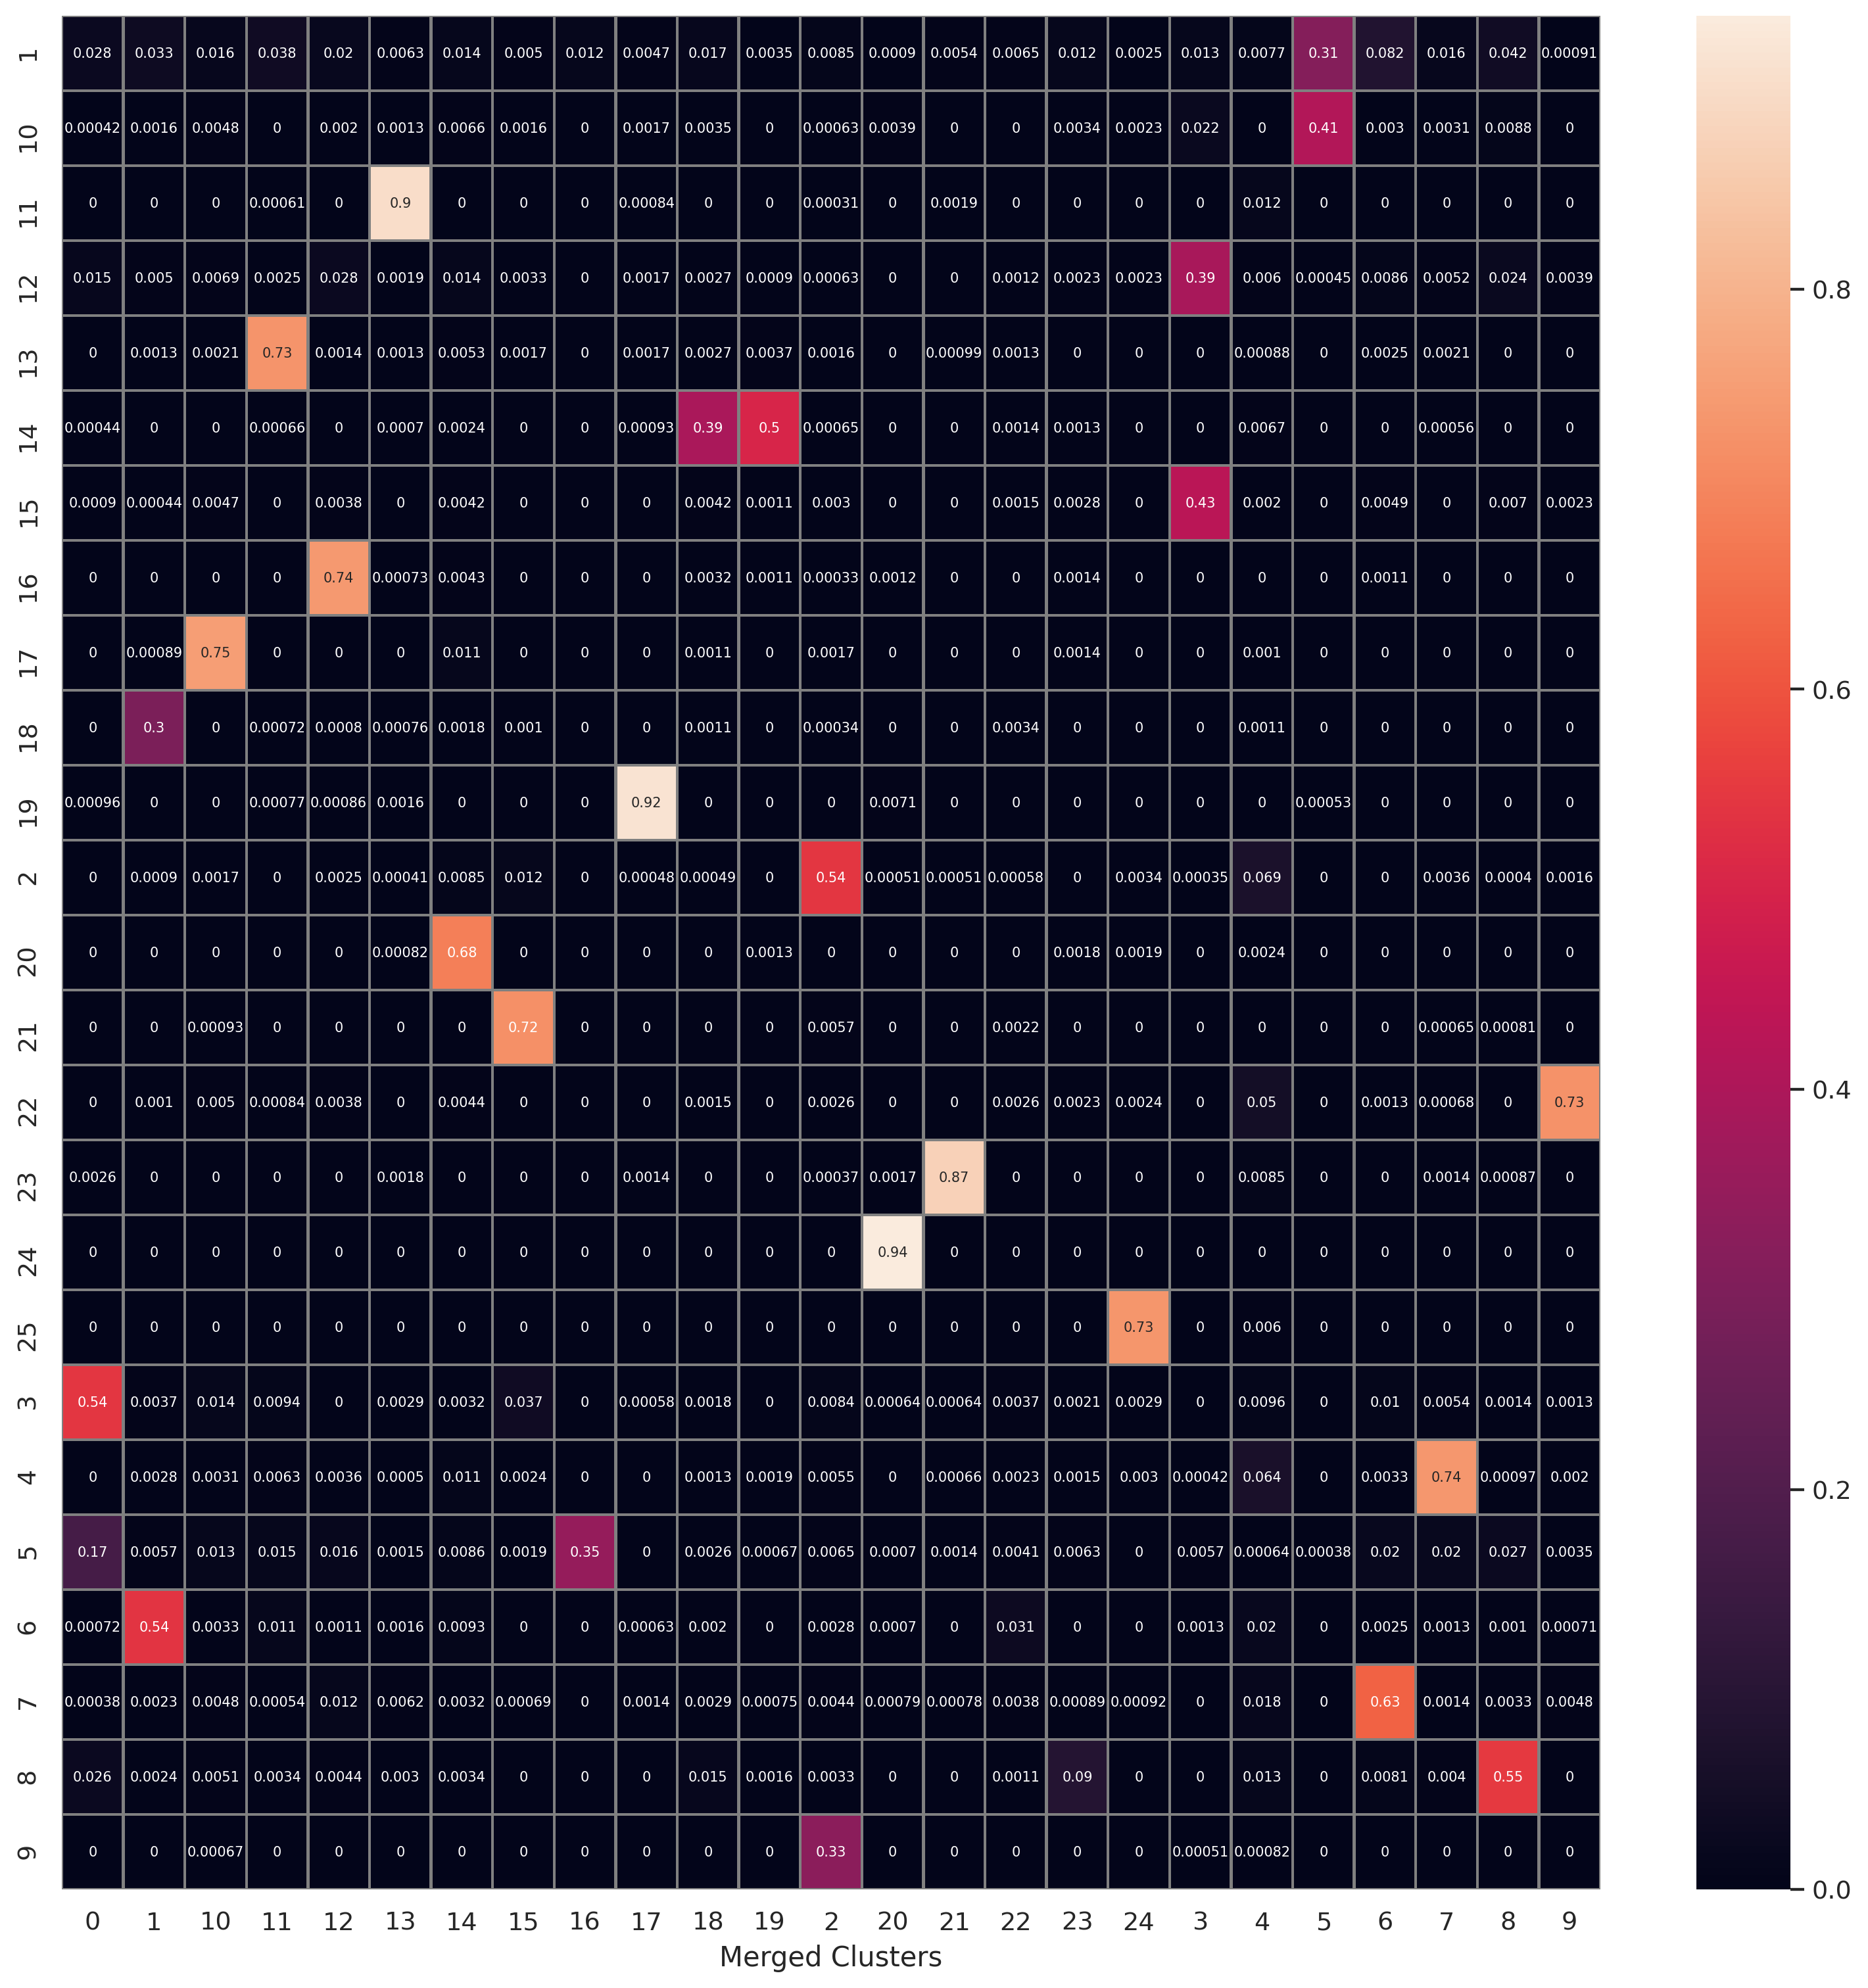

In [32]:
#Separate cells from each experiment
adata_stim = combo[combo.obs['cell_origin'].isin(['IEG'])]
adata_stim

#Jaccard index for stimulation data and scVI merged atlas
stim_clusters = np.unique(adata_stim.obs['leiden_scVI']) 
bus_stim_clusters = np.unique(bus_stim.obs['leiden'])

#Dataframe for overlap scores
clusterScores_bus = pd.DataFrame(index=bus_stim_clusters, columns=stim_clusters)

#Remove experimental identifier from cell barcodes
adata_stim.obs_names = [s.replace('_ieg', '') for s in adata_stim.obs_names] 

for i in stim_clusters:
    #Get cell barcodes in each cluster
    sub =  adata_stim[adata_stim.obs['leiden_scVI'].isin([i])]
    sub_cells =  list(sub.obs_names)
    scores = []

    for j in bus_stim_clusters:
        #Get cell barcodes in each cluster
        bus_stim_sub =  bus_stim[bus_stim.obs['leiden'].isin([j])]
        bus_stim_sub_cells =  list(bus_stim_sub.obs_names)

        #Jaccard score calculation
        union = set(sub_cells).union(bus_stim_sub_cells)
        intersect = set(sub_cells).intersection(bus_stim_sub_cells)
        scores.append(len(intersect)/len(union))


    clusterScores_bus[i] = scores
    
plt.figure(figsize=(15,15))
ax = sns.heatmap(clusterScores_bus,annot=True, annot_kws={"size": 6},linewidths=1, linecolor='grey')
ax.set(xlabel='Merged Clusters')
plt.show()

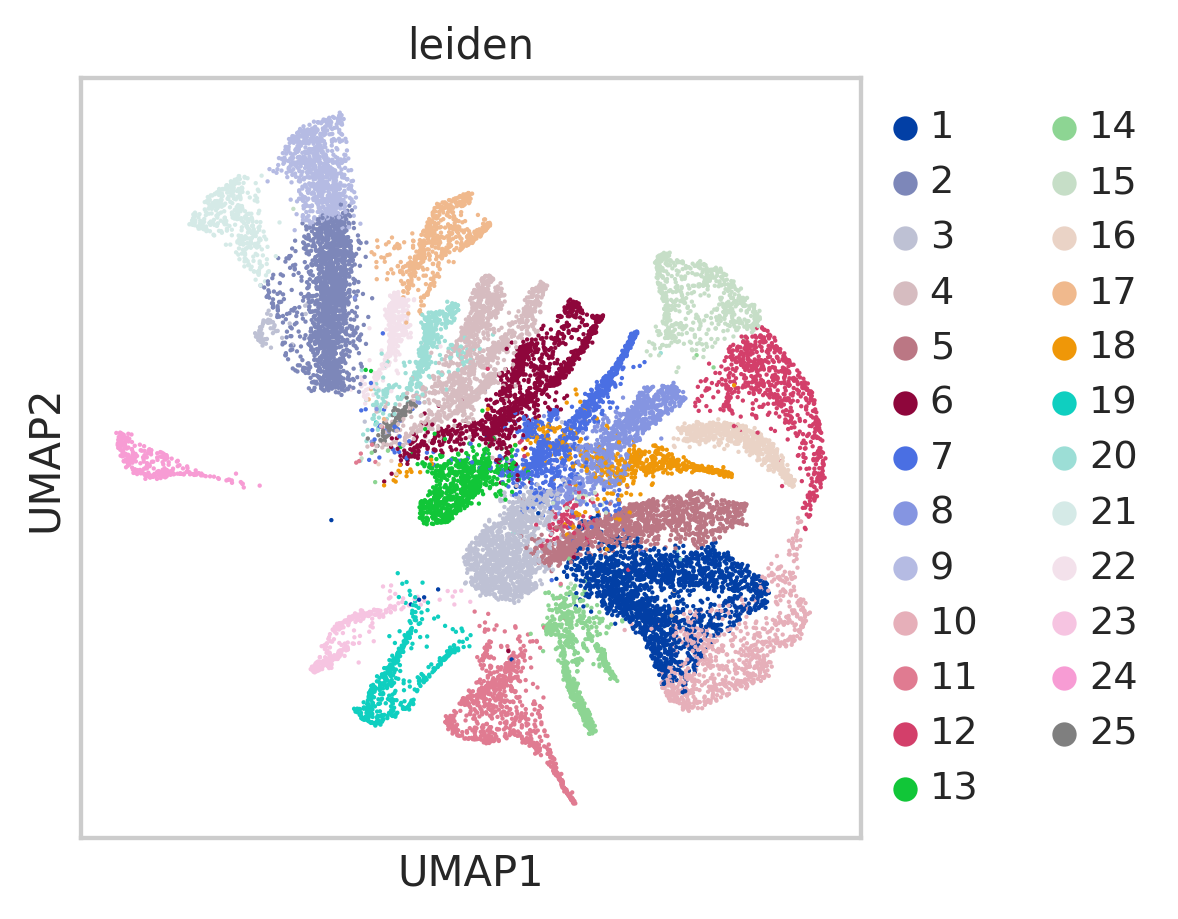

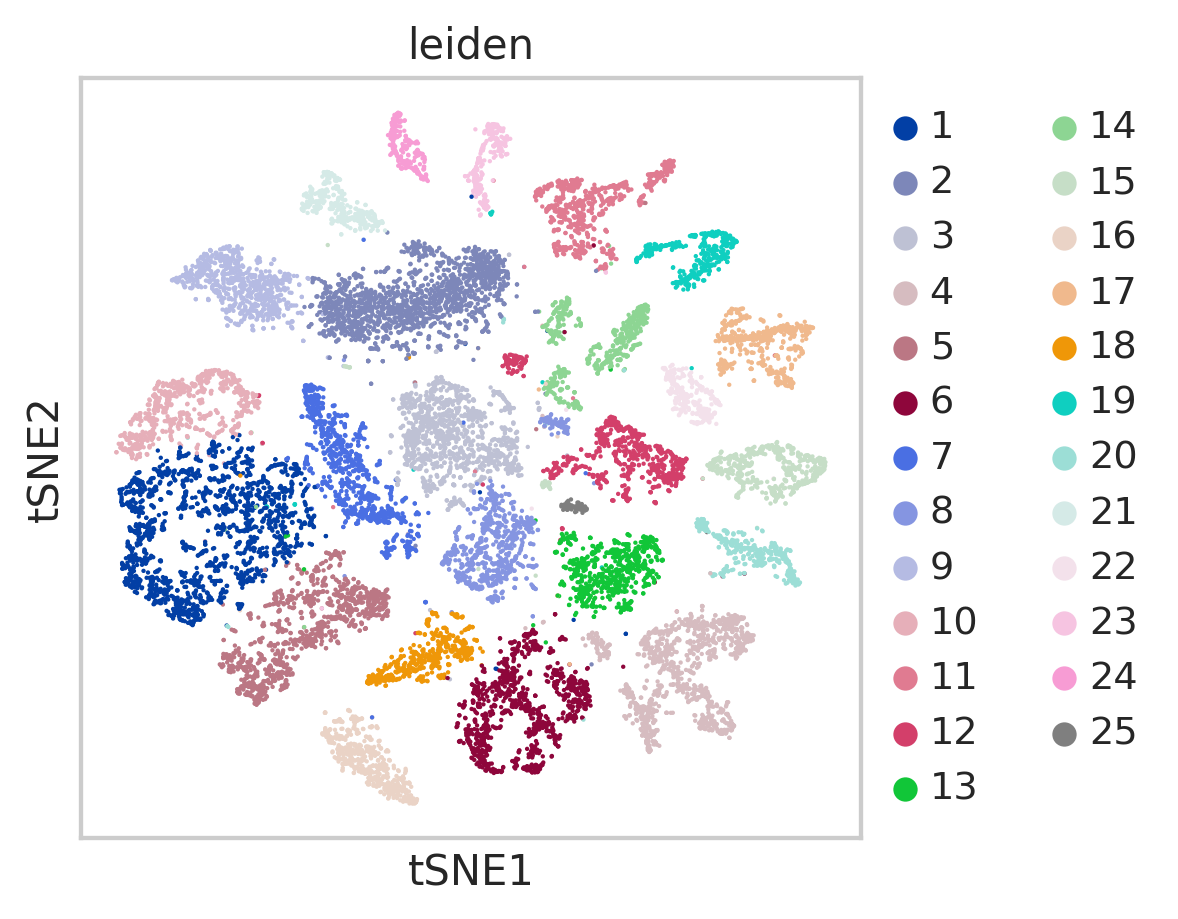

In [39]:
sc.pl.umap(bus_stim,color=['leiden'],color_map = 'viridis')
#After nca, testing out different visualizations
sc.pl.tsne(bus_stim,color=['leiden'],color_map = 'viridis')